In [1]:
%matplotlib inline
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from pandas.plotting import scatter_matrix 
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.preprocessing import image

Построим датасет из исходных изобраений применив к ним различные трансформации

In [2]:
image_size = (128, 128)
batch_size = 32
base_dir = 'flowers'


train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2,  
                                   zoom_range=0.2, horizontal_flip=True, 
                                   validation_split=0.2) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2,  
                                   zoom_range=0.2, horizontal_flip=True, 
                                   validation_split=0.2)  
  
train_data = train_datagen.flow_from_directory(base_dir, 
                                               target_size=image_size, 
                                               subset='training', 
                                               batch_size=batch_size, 
                                               class_mode='categorical') 
val_data = test_datagen.flow_from_directory(base_dir,
                                            target_size=image_size,
                                            subset='validation',
                                            batch_size=batch_size, 
                                            class_mode='categorical') 


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


Создадим модель сверточной нейронной сети и обучим её

In [3]:
model = Sequential() 
model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation="softmax")) 


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=20, batch_size=32, validation_data=val_data)

Epoch 1/20


C:\Users\mkiri\anaconda3\envs\tf_keras\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 659ms/step - accuracy: 0.3348 - loss: 1.4424 - val_accuracy: 0.5640 - val_loss: 1.0997
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 677ms/step - accuracy: 0.5620 - loss: 1.0998 - val_accuracy: 0.6267 - val_loss: 0.9594
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 699ms/step - accuracy: 0.6198 - loss: 0.9768 - val_accuracy: 0.6140 - val_loss: 0.9710
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 85s 761ms/step - accuracy: 0.6385 - loss: 0.9068 - val_accuracy: 0.6372 - val_loss: 0.9128
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 729ms/step - accuracy: 0.6556 - loss: 0.8657 - val_accuracy: 0.6570 - val_loss: 0.8696
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 80s 713ms/step - accuracy: 0.7010 - loss: 0.8173 - val_accuracy: 0.6105 - val_loss: 1.0102
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 80s 720ms/step - accuracy: 0.7044 - loss: 0.7955 - val_accuracy: 0.6744 - val_loss: 0.8114
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 80s 718ms/step - accuracy: 0.7002 - loss: 0.7490 - val

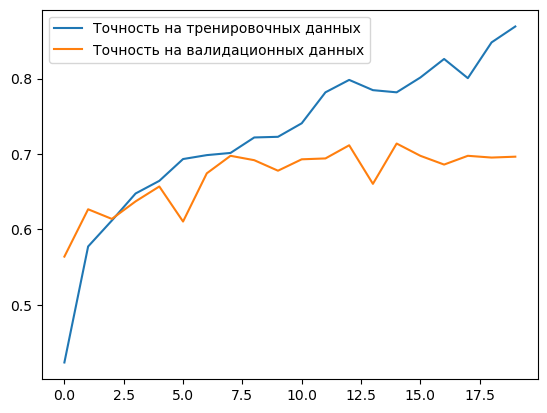

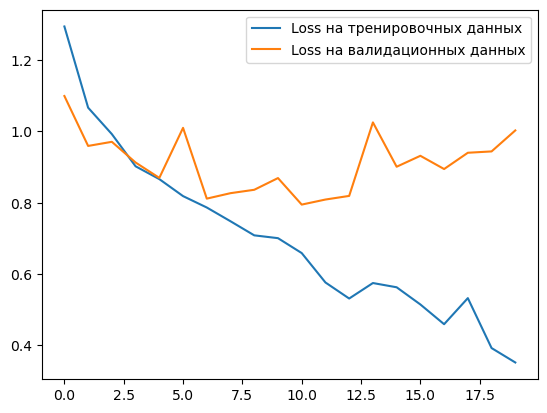

In [5]:
plt.plot(history.history['accuracy'], label='Точность на тренировочных данных')
plt.plot(history.history['val_accuracy'], label='Точность на валидационных данных')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss на тренировочных данных')
plt.plot(history.history['val_loss'], label='Loss на валидационных данных')
plt.legend()
plt.show()

Создадим автоэнкодер и обучим его, для того, чтобы использовать в классификаторе на основе полносвязных слоёв.

In [6]:
input_img = tf.keras.Input(shape=(128, 128, 3))
x = layers.Flatten()(input_img)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
encoded = layers.Dense(64, activation='relu')(x)


x = layers.Dense(128, activation='relu')(encoded)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128 * 128 * 3, activation='sigmoid')(x)
decoded = layers.Reshape((128, 128, 3))(x)

autoencoder = tf.keras.Model(input_img, decoded)
encoder = tf.keras.Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
all_x = []

for _ in range(len(train_data)):
    x_batch, _ = next(train_data)
    all_x.append(x_batch)

all_x = np.vstack(all_x)

all_x_dev = []

for _ in range(len(val_data)):
    x_batch, _ = next(val_data)
    all_x_dev.append(x_batch)

all_x_dev = np.vstack(all_x_dev)

In [12]:
autoencoder.compile(optimizer='adam', loss='mse')
history_ae = autoencoder.fit(all_x, all_x, validation_data=(all_x_dev, all_x_dev), epochs=20)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - loss: 0.0747 - val_loss: 0.0586
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 30s 272ms/step - loss: 0.0557 - val_loss: 0.0648
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 256ms/step - loss: 0.0576 - val_loss: 0.0529
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - loss: 0.0484 - val_loss: 0.0490
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 29s 263ms/step - loss: 0.0460 - val_loss: 0.0479
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 31s 279ms/step - loss: 0.0438 - val_loss: 0.0448
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - loss: 0.0415 - val_loss: 0.0521
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - loss: 0.0447 - val_loss: 0.0435
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step - loss: 0.0387 - val_loss: 0.0410
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 334ms/step - loss: 0.0398 - val_loss: 0.0392
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 300ms/step - loss: 0.0365 - val_loss: 0.0381
Epoch 12/20
109/109

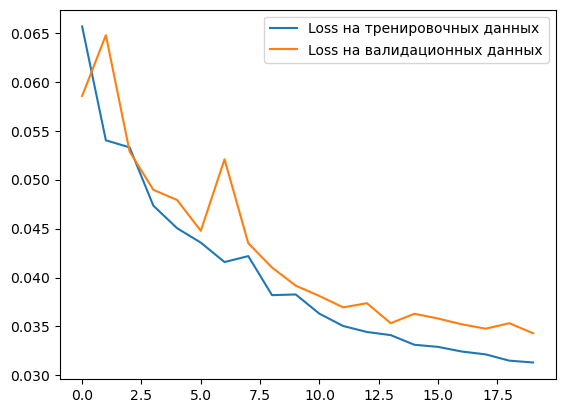

In [13]:
plt.plot(history_ae.history['loss'], label='Loss на тренировочных данных')
plt.plot(history_ae.history['val_loss'], label='Loss на валидационных данных')
plt.legend()
plt.show()

Создадим классификатор на основе полносвязных слоёв, который будет использовать encoder для сжатия изображения

In [14]:
for layer in encoder.layers:
    layer.trainable = False


classifier_input = encoder.input
x = encoder.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)

classifier = tf.keras.Model(classifier_input, output)

In [15]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cls = classifier.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 66s 545ms/step - accuracy: 0.2950 - loss: 2.3897 - val_accuracy: 0.3884 - val_loss: 1.3614
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 519ms/step - accuracy: 0.3881 - loss: 1.4225 - val_accuracy: 0.4140 - val_loss: 1.2923
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 59s 518ms/step - accuracy: 0.3970 - loss: 1.3694 - val_accuracy: 0.4593 - val_loss: 1.2614
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 519ms/step - accuracy: 0.4349 - loss: 1.2946 - val_accuracy: 0.4174 - val_loss: 1.2761
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 59s 517ms/step - accuracy: 0.4510 - loss: 1.2716 - val_accuracy: 0.4395 - val_loss: 1.2608
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 540ms/step - accuracy: 0.4463 - loss: 1.2965 - val_accuracy: 0.4302 - val_loss: 1.2447
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 518ms/step - accuracy: 0.4664 - loss: 1.2696 - val_accuracy: 0.4430 - val_loss: 1.2450
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 66s 577ms/step - accuracy: 0.4613 - loss: 1

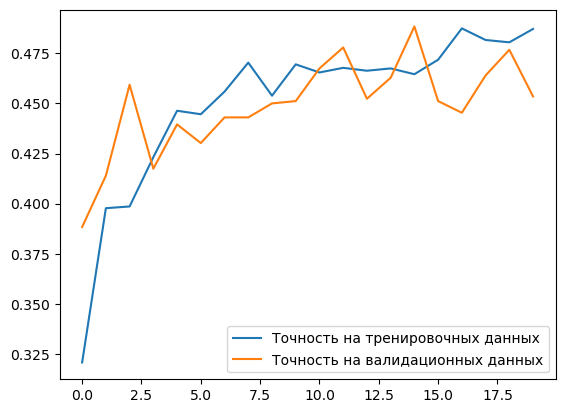

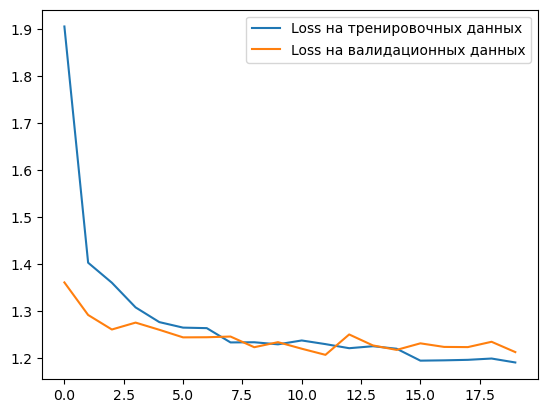

In [16]:
plt.plot(history_cls.history['accuracy'], label='Точность на тренировочных данных')
plt.plot(history_cls.history['val_accuracy'], label='Точность на валидационных данных')
plt.legend()
plt.show()

plt.plot(history_cls.history['loss'], label='Loss на тренировочных данных')
plt.plot(history_cls.history['val_loss'], label='Loss на валидационных данных')
plt.legend()
plt.show()

Сравним полученные модели сверточной нейронной сети и классификатора на основе полносвязных слоёв по метрике accuracy

In [17]:
_, acc_cnn = model.evaluate(val_data)
_, acc_dense = classifier.evaluate(val_data)

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - accuracy: 0.7073 - loss: 0.9588
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.4873 - loss: 1.1872


In [18]:
print(f"Accuracy для сверточной: {acc_cnn:.4f}")
print(f"Accuracy для полносвязной: {acc_dense:.4f}")

Accuracy для сверточной: 0.6895
Accuracy для полносвязной: 0.4849


Как можно заметить, лучший результат показала свёрточная модель. 
Её точность по метрике accuracy составляет 0.7081

Для демонстрация результата обучим модель большим количество эпох и посмотрим на результат на примере нескольких картинок

In [19]:
history = model.fit(train_data, epochs=100, validation_data=val_data)

Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 91s 822ms/step - accuracy: 0.8720 - loss: 0.3505 - val_accuracy: 0.7256 - val_loss: 0.9882
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 90s 814ms/step - accuracy: 0.8993 - loss: 0.2867 - val_accuracy: 0.7000 - val_loss: 1.1406
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 92s 815ms/step - accuracy: 0.8964 - loss: 0.2797 - val_accuracy: 0.7244 - val_loss: 1.1090
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 91s 819ms/step - accuracy: 0.9014 - loss: 0.2702 - val_accuracy: 0.7209 - val_loss: 0.9181
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 90s 814ms/step - accuracy: 0.8817 - loss: 0.3269 - val_accuracy: 0.7093 - val_loss: 1.1042
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 87s 793ms/step - accuracy: 0.9187 - loss: 0.2472 - val_accuracy: 0.7047 - val_loss: 1.1995
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 87s 780ms/step - accuracy: 0.9205 - loss: 0.2149 - val_accuracy: 0.6942 - val_loss: 1.2047
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 91s 823ms/step - accuracy: 0.9161 -

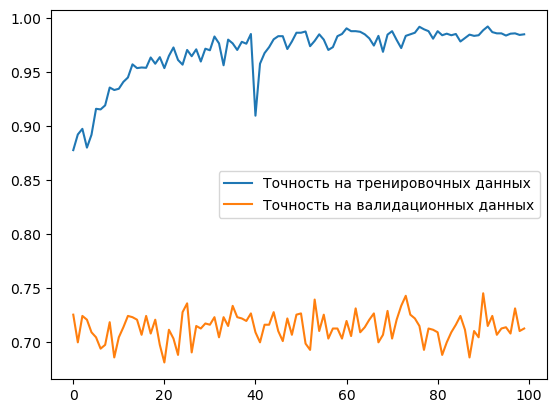

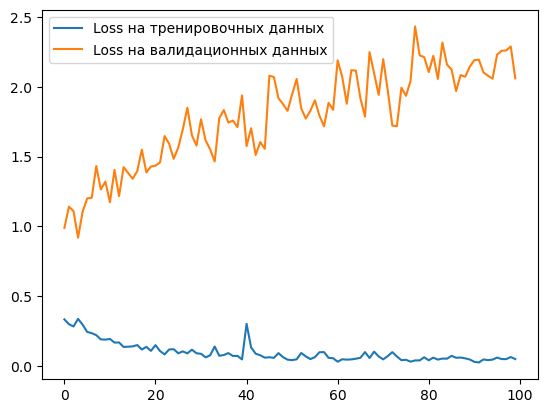

In [20]:
plt.plot(history.history['accuracy'], label='Точность на тренировочных данных')
plt.plot(history.history['val_accuracy'], label='Точность на валидационных данных')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss на тренировочных данных')
plt.plot(history.history['val_loss'], label='Loss на валидационных данных')
plt.legend()
plt.show()

На графике видно переобучение